# Segmenting Lung X-ray Images with the Segment Anything Model

## Set-up

Imports and helper functions for displaying points, boxes, and masks.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


# Download model:

In [5]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

Checkpoint file already exists. Skipping download.


In [6]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

c:\Users\ander\anaconda3\envs\adl\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Den angivne procedure blev ikke fundet'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Chest X-ray Dataset

In [7]:
import os
from torchvision.datasets.utils import download_url

In [10]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

Using existing ./datasets\lung_field_dataset.npz


In [11]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask
    
    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")
    
    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [12]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

Initial shapes:
x_train: (112, 256, 256, 1)
y_train: (112, 256, 256, 1)
x_val: (12, 256, 256, 1)
y_val: (12, 256, 256, 1)
x_test: (123, 256, 256, 1)
y_test: (123, 256, 256, 1)
Transformed shapes:
x_train: (112, 256, 256, 3)
y_train: (112, 256, 256)
x_val: (12, 256, 256, 3)
y_val: (12, 256, 256)
x_test: (123, 256, 256, 3)
y_test: (123, 256, 256)


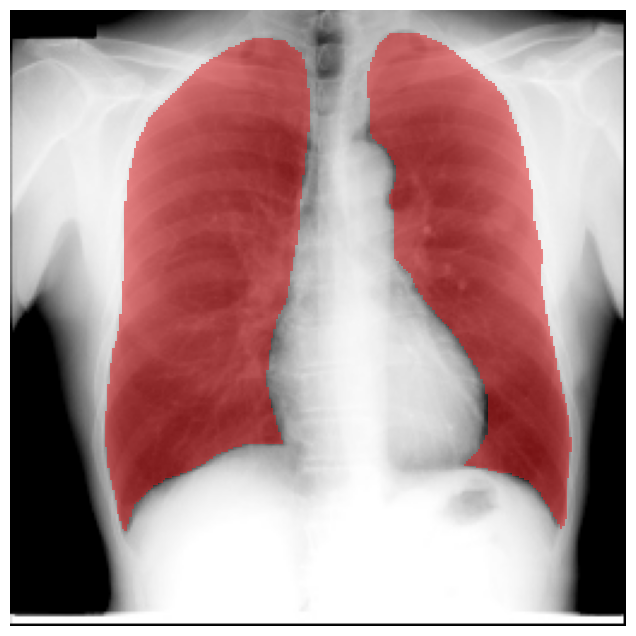

In [13]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

#print(x_train[1])

# Print initial shapes
print("Initial shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

# Transform the data

def preprocess_X(images):
    # Remove "1", i.e. the extra dimension
    images = images.squeeze()
    images_rgb = np.stack([images, images, images], axis=-1)
    images_rgb = map_interval(images_rgb, images_rgb.min(), images_rgb.max(), 0, 255).astype(np.uint8)
    return images_rgb

x_train = preprocess_X(x_train)
x_val = preprocess_X(x_val)
x_test = preprocess_X(x_test)

# Convert masks to [0, 255]
def preprocess_Y(masks):
    # Remove extra dimension
    masks = masks.squeeze()
    return map_interval(masks, masks.min(), masks.max(), 0, 255).astype(np.uint8)

y_train = preprocess_Y(y_train)
y_val = preprocess_Y(y_val)
y_test = preprocess_Y(y_test)

# Apply the transformation
#x_train, y_train = transform_data(x_train, y_train)
#x_val, y_val = transform_data(x_val, y_val)
#x_test, y_test = transform_data(x_test, y_test)

# Print transformed shapes
print("Transformed shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

# Single Example image

Let's try to run SAM on a single example image

In [14]:
example_img, example_mask = x_train[0], y_train[0]

# Appropiate points (Inside and outside)
input_points = np.array([[60, 170], [90, 100], [170, 70], [200, 160], [50, 50], [100, 200]])
input_label = np.array([1, 1, 1, 1, 0, 0])  # 1 for points inside the lung, 0 for points outside

example_img.shape

(256, 256, 3)

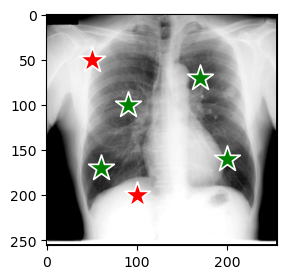

In [15]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca()) # You may also use other prompt methods!
plt.axis('on')
plt.show()

In [16]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

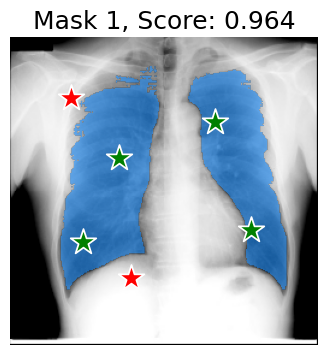

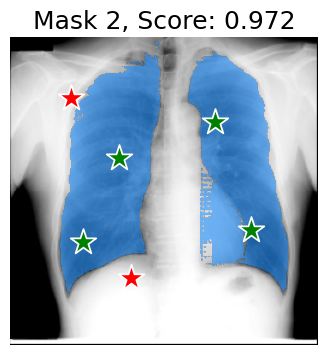

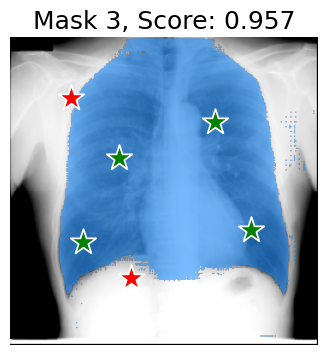

In [17]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Evaluation loop

In [18]:
import torchmetrics

f1 = torchmetrics.F1Score(task="binary")

f1_scores = []

# Appropiate points (Inside and outside)
input_points = np.array([[60, 170], [90, 100], [170, 70], [200, 160], [50, 50], [100, 200]])
input_label = np.array([1, 1, 1, 1, 0, 0])  # 1 for points inside the lung, 0 for points outside

#example_img, example_mask = x_train[0], y_train[0]
#predictor.set_image(example_img)

for img, mask_gt in zip(x_val[:5], y_val[:5]): #5 first
    
    # Set the image in predictor
    predictor.set_image(img)
    
    # Predict segmentation with SAM
    mask_pred, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        multimask_output=False, #False to get 1
    )
    
    # Convert predicted mask to binary
    mask_pred = mask_pred.squeeze()
    mask_pred = (mask_pred > 0.5).astype(np.uint8)

    # Convert ground truth mask to binary [0, 1]
    mask_gt = (mask_gt > 0).astype(np.uint8)
    
    # Compute F1 score
    f1_score = f1(torch.tensor(mask_pred), torch.tensor(mask_gt))
    f1_scores.append(f1_score.item())

# Compute mean and standard deviation of F1 scores
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

Mean F1 score: 0.8065
Standard deviation: 0.1164


# Using Bounding Boxes from GT segmentations as Prompt

[[ 39  11 125 218]
 [148   8 234 217]]
tensor([[ 39,  11, 125, 218],
        [148,   8, 234, 217]], dtype=torch.int32)


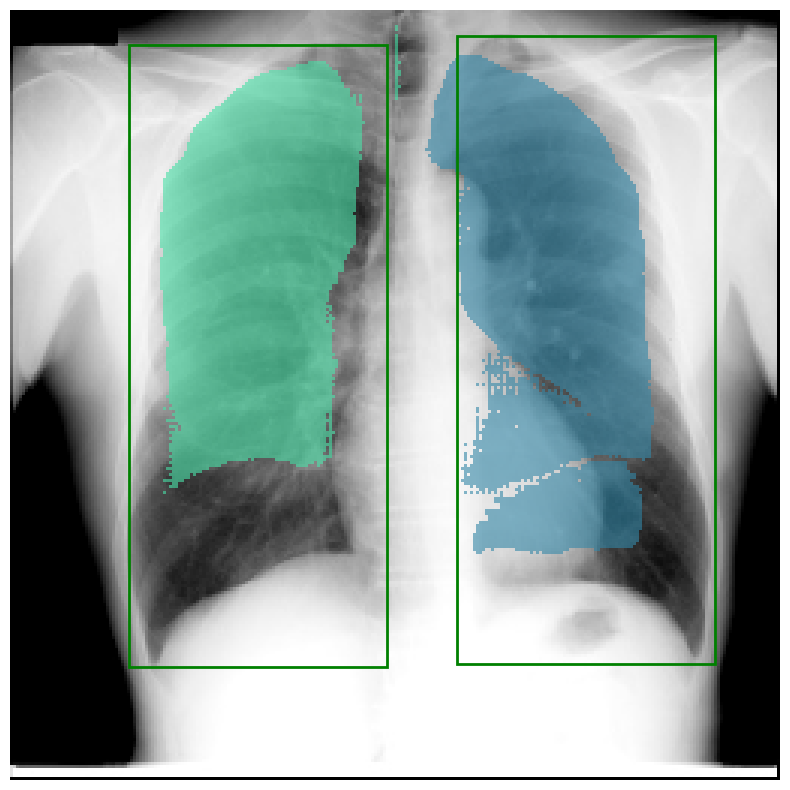

In [37]:
# bounding boxes from segmentation masks
# bounding box format [x0, y0, x1, y1]

import cv2

def generate_bounding_box(mask):

    # Convert mask to binary image - pas på vi ikke allerede har gjort
    binary = (mask > 0).astype(np.uint8) * 255

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Compute bounding boxes
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append([x, y, x + w, y + h])

    return np.array(bounding_boxes)

#example_img, example_mask = x_train[0], y_train[0]

test_mask_box = generate_bounding_box(example_mask)

print(test_mask_box)

input_boxes = torch.tensor(test_mask_box, device=predictor.device)

print(input_boxes)

#print(input_boxes1)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, example_img.shape[:2])

masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(example_img)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()



In [39]:
# F1 score / Standard Deviation

for img, mask_gt in zip(x_val[:5], y_val[:5]): #5 first

    predictor.set_image(img) # Set predictor

    input_box = generate_bounding_box(mask_gt)

    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, example_img.shape[:2])
    
    masks_pred, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )

    # Convert predicted mask to binary
    mask_pred = mask_pred.squeeze()
    mask_pred = (mask_pred > 0.5).astype(np.uint8)

    # Convert ground truth mask to binary [0, 1]
    mask_gt = (mask_gt > 0).astype(np.uint8)
    
    # Compute F1 score
    f1_score = f1(torch.tensor(mask_pred), torch.tensor(mask_gt))
    f1_scores.append(f1_score.item())

# Compute mean and standard deviation of F1 scores
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

Mean F1 score: 0.7030
Standard deviation: 0.1055
